In [1]:
import pandas as pd
import numpy as np
import torch
from csdi import CSDI_base
import matplotlib.pyplot as plt
from utils import *
from calc_metrics import *
from training import train, evaluate, impute
import warnings 
from preprocessing import SegmentStandardScaler, get_data_MCAR, get_data_missing_intervals
import datetime
import torch
warnings.filterwarnings('ignore')
import random
np.random.seed(123)

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

In [2]:
torch.cuda.empty_cache()
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

## Setting up the parameters

In [3]:
# =========================================
# Define params

length_of_intervals = 30 # length of missing intervals
num_of_intervals = 3 # number of intervals wioth missing values
length_of_seq = 100 # length of dataframe slice used for training
sigma_GP = 0.02 # variance parameter of DSPD model
use_DSPD = False # flag for using DSPS (if False, original CSDI is being trained)
df_name = 'Exchange' # name of the dataframe
# df_len  = 1000

# =========================================

## Preprocessing

In [4]:
# load the data
df_train_nm = get_data_missing_intervals(df_name) 
df = get_data_missing_intervals(df_name, create_misses = True, length_of_intervals = length_of_intervals, num_of_intervals = num_of_intervals)

# save indexes of missing values
missing_values = df[df.target.isna()].index.values

# scale the data
sc_train = SegmentStandardScaler(segments=df.segment.unique())
df_train = sc_train.fit_transform(df.copy())
df_train_only_missed = sc_train.transform(df_train_nm.sort_values(['timestamp', 'segment'])[df_train_nm.index.isin(missing_values)])
df_train_only_not_missed = sc_train.transform(df_train_nm.sort_values(['timestamp', 'segment'])[~df_train_nm.index.isin(missing_values)])

In [5]:
# create datasets - one for the training and one for the imputation
cust_df_train = Custom_Dataset(df_train, length_of_sequence=length_of_seq)
cust_df_test = Custom_Dataset(df_train, length_of_sequence=length_of_seq, use_rolling_window = False)

In [6]:
# create custom dataloader
df_train_load = DataLoader(cust_df_train, batch_size=64, shuffle=1)

## Training

In [7]:
# initialize the imputer
CSDI = CSDI_base(target_dim = df_train_nm.segment.nunique(),
                 emb_feature_dim = 16, 
                 emb_time_dim = 128, 
                 diffusion=128, 
                 diffusion_embedding_dim=128, 
                 device = dev, 
                 num_steps= 50, 
                 gp_noise=use_DSPD, 
                 gp_sigma=sigma_GP
                )
CSDI.to(dev)

CSDI_base(
  (embed_layer): Embedding(8, 16)
  (diffmodel): diff_CSDI(
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=8, out_features=8, bias=True)
      (projection2): Linear(in_features=8, out_features=8, bias=True)
    )
    (input_projection): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
    (output_projection1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (output_projection2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
    (residual_layers): ModuleList(
      (0-3): 4 x ResidualBlock(
        (diffusion_projection): Linear(in_features=8, out_features=64, bias=True)
        (cond_projection): Conv1d(145, 128, kernel_size=(1,), stride=(1,))
        (mid_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (output_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (time_layer): TransformerEncoder(
          (layers): ModuleList(
            (0): TransformerEncoderLayer(
              (self_attn): Multihea

In [8]:
# train the imputer
train(CSDI,
      df_train_load,
      epochs= 200,
      learning_rate= 1e-3
      )

100%|██████████| 7/7 [00:01<00:00,  5.04it/s, avg_epoch_loss=0.056, epoch=199]


## Imputation and evaluation

In [9]:
# generate the 100 imputed values for each miss
gen_iters = 100

res_imputed = []
for i in range(gen_iters):
    imputed_values = impute(CSDI, cust_df_test, length_of_sequence = length_of_seq, num_of_timestamps = 500, use_rolling_window = False )
    imputed_values.columns = df_train.segment.unique()
    imputed_values['date'] = df_train.timestamp.sort_values().unique()
    imp_transf = transform_format(imputed_values, imputed_values.columns[:-1])
    imp_transf.timestamp = imp_transf.timestamp.values.astype(int)
    sc_transf = imp_transf.sort_values(['timestamp', 'segment']).reset_index(drop = True)
    res_imputed.append(sc_transf[sc_transf.index.isin(missing_values)].sort_index())
    print(str(i+1), '/', str(gen_iters))

1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


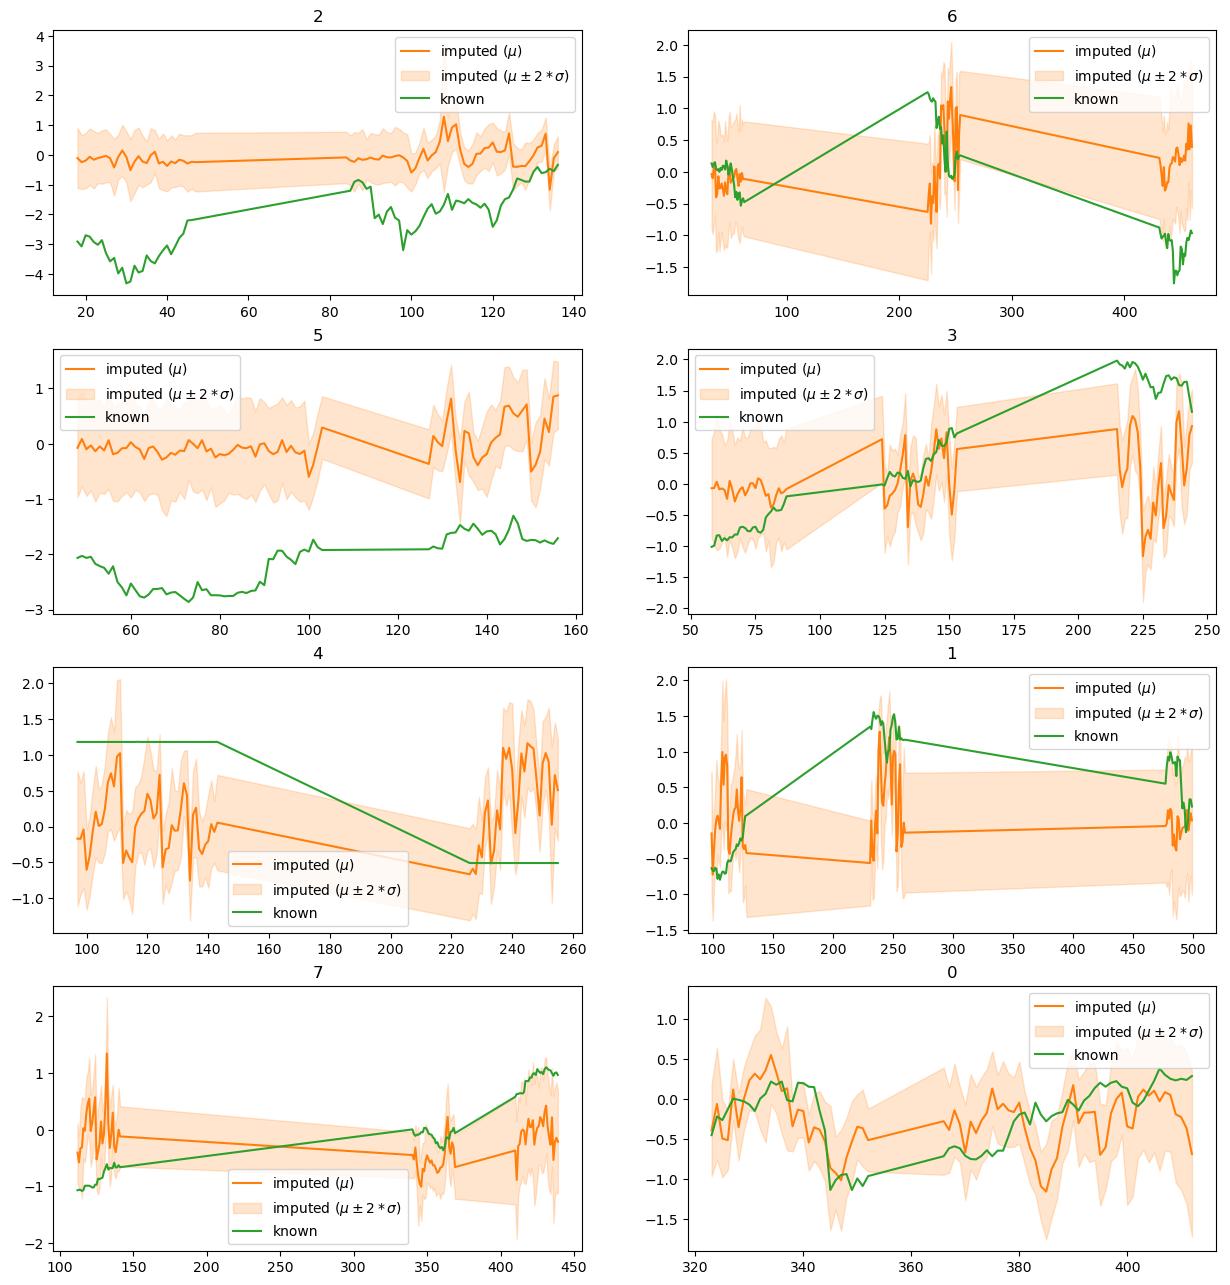

In [10]:
# plot the imputed intervals
plot_intervals(df_train_only_missed, res_imputed, df_train_only_missed.segment.unique())

In [11]:
# compute quality metrics report
quality_metrics_report(res_imputed, df_train_only_missed, df_train_only_missed.segment.unique())


,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEp,PICP_68,PICP_95
2,2.336966,2.114549,2.272674,2.455917,100.678392,16.76145,5.795865,0.0,0.108434
6,1.032458,0.853189,1.314654,1.291689,1004.470261,3.176273,2.513497,0.3,0.488889
5,2.200308,2.152342,4.799936,5.183611,100.373534,17.438997,5.918591,0.0,0.0
3,1.074426,0.834011,1.069489,0.93793,212.167645,6.548203,3.655415,0.277778,0.588889
4,1.159115,1.051787,1.406539,1.308592,129.03223,7.686653,3.985564,0.12987,0.220779
1,0.923524,0.770769,1.1505,1.047104,126.940832,3.91269,2.838603,0.253012,0.60241
7,0.847194,0.761611,1.148545,1.220687,2329.379885,2.80961,2.458248,0.055556,0.411111
0,0.423323,0.353449,1.029107,1.035371,356.270664,0.993323,1.64912,0.506494,0.766234


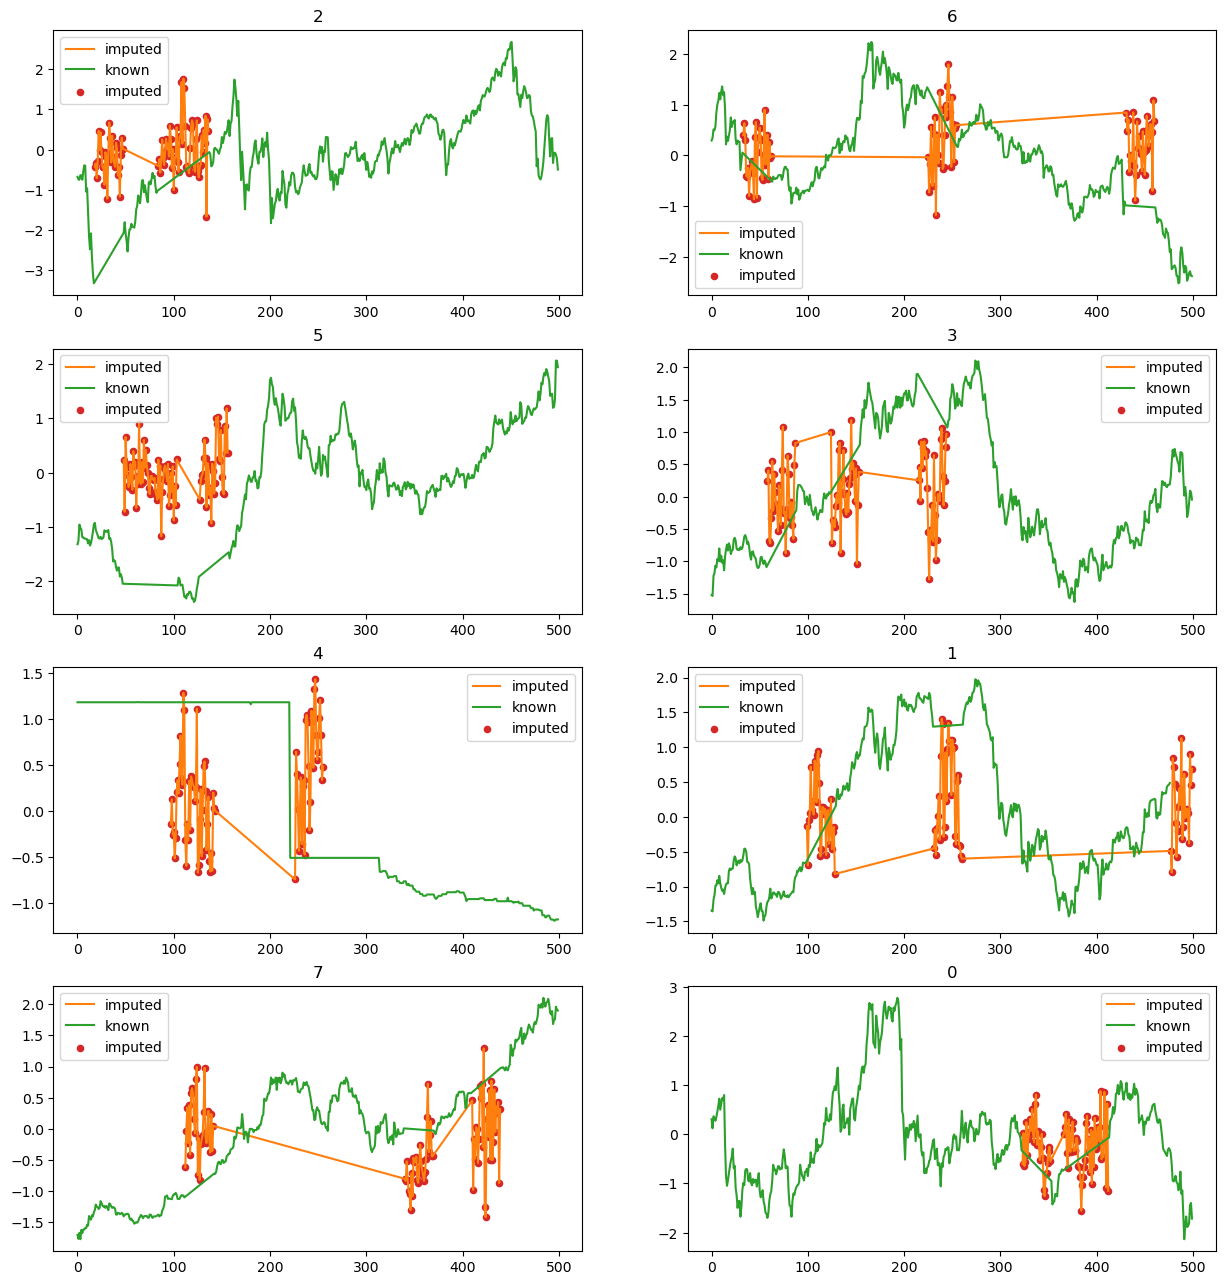

In [12]:
# plot one trajectory of imputed values
plot_predictions(df_train_only_not_missed, 
                       res_imputed[0], 
                       df_train_only_missed[['timestamp','segment']], 
                       df_train_only_missed.segment.unique())